In [ ]:
# example taken from http://madhugnadig.com/articles/machine-learning/2017/03/04/implementing-k-means-clustering-from-scratch-in-python.html
# github: https://github.com/madhug-nadig/Machine-Learning-Algorithms-from-Scratch/blob/master/K%20Means%20Clustering.py

In [31]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd 
from scipy.interpolate import lagrange

from smpc_secrets import ShamirSecretSharing, AdditiveSecretSharing, Vandermonde, P, RandPoly

style.use('ggplot')
%matplotlib inline

In [100]:
class PeerToPeer:
    def __init__(self, k):
        self.k=k
        self.shares = np.array([])
        
       
    def get_shares(self,data):
        n=len(data)
        t=self.k
        for point in data:
            X = data[0]
            Y = data[1]
            shares = self._get_shares(X,Y)
            self.shares = np.append(self.shares, shares)
        
        return shares
            
            
            
    def _get_shares(self,X,Y):
        n=2
        t=2
        # Alice
        alice = ShamirShare(id=1, t=t, n=n, secrets=X)
        # Bob
        bob = ShamirShare(id=2, t=t, n=n, secrets=Y)

        # polynomials
        f = [alice.computations[i][0].poly for i in range(n)]
        g = [bob.computations[i][0].poly for i in range(n)]

        alice_id = 1
        alice_points = np.array([(f[i](alice_id), g[i](alice_id)) for i in range(n)])

        # Bob's polynomials
        bob_id = 2
        bob_points = np.array([(f[i](bob_id), g[i](bob_id)) for i in range(n)])

        # server computes d1(1)^2 and d2(1)^2
        server_id=3
        server_points = np.array([(f[i](server_id),g[i](server_id)) for i in range(n)])
        return np.stack((alice_points, bob_points, server_points))

In [65]:
class ShamirShare:
    def __init__(self,id, t, n, secrets):
        self.computations = []
        self.all_shares = []
        self.id = id
        for secret in secrets:
            shamir = ShamirSecretSharing(n=n, t=t)
            shares = shamir.generate(s=secret)
            self.all_shares.append(shares)
            self.computations.append((shamir, shares))
        self.shares = self.get_share(id)
        
    
    def get_share(self,id):
        return [shares[id][1] for shares in self.all_shares]
        
    def reconstruct(self):
        secrets = []
        for shamir, shares in self.computations:
            secrets.append(shamir.reconstruct(shares=shares))
        return secrets
    
    def _compute(self, other, op):
        assert len(self.shares) == len(other)
        for i in range(len(self.shares)):
            self.shares[i] = op(self.shares[i], other[i])
    
    def __add__(self,other):
        op = lambda x,y: x+y
        self._compute(self.shares, other, add)
        
    def __sub__(self,other):
        op = lambda x,y: x-y
        self._compute(self.shares, other, add)
        
    def __pow__(self, other):
        for i in range(len(self.shares)):
            self.shares[i] **= 2

In [76]:
def secure_euclidean_distance(shares):
        d = [[np.power(point[0] - point[1],2) for point in share] for share in shares]
        dist = np.sum(d, axis=1)
        x = np.arange(1,len(dist)+1)
        y = dist
        f = lagrange(x, y)
        return np.sqrt(f(0))

In [77]:
def euclidean_distance(X, Y):
    dist = 0
    for i in range(len(X)):
        dist += (X[i] - Y[i]) ** 2
    return np.sqrt(dist)

def norm(X, Y):
    return np.linalg.norm(X-Y)

In [78]:
X=[1,3]
Y=[4,2]
data_point = np.array([X, Y])
data_point
p2p = PeerToPeer(k=2)
shares = p2p.get_shares(data_point)
secure_euclidean_distance(shares)

3.1622776601683795

In [79]:
class KMeans:
    def __init__(self, k=3, distance_function=norm, epsilon=1e-3, max_iter=500):
        self.k = k # number of clusters
        self.epsilon = epsilon # tolerance
        self.max_iter = max_iter # max iterations
#         self.distance_function = distance_function
        
    def fit(self, data):
        # shares data: features and centroids
        self.centroids = {}
        
        # initialize centroids
        for i in range(self.k):
            self.centroids[i] = data[i]
        
        # iterative clustering
        for i in range(self.max_iter):
            self.classes = {}
            for i in range(self.k):
                self.classes[i] = []
            # find nearest centroid
            for features in data:
                # step 1: compute squared distances (features, centroids)
#                 distances = [self.distance_function(features, self.centroids[centroid]) for centroid in self.centroids]
                distances = [secure_euclidean_distance(p2p.get_shares([features, self.centroids[centroid]])) for centroid in self.centroids]
                
                classification = np.argmin(distances)
                self.classes[classification].append(features)
                
            previous = dict(self.centroids)
            
            for classification in self.classes:
                # maybe secure average
                self.centroids[classification] = np.average(self.classes[classification], axis=0)
                
            is_optimal = True
            
            # reconstruct
            for centroid in self.centroids:
                original_centroid = previous[centroid]
                current_centroid = self.centroids[centroid]
                
                # not sure we need to do it securely
                if np.sum((current_centroid  - original_centroid)/original_centroid * 100.0) > self.epsilon:
                    is_optimal = False
                    
            if is_optimal:
                break
              
            
    def pred(self, data):
        # nearest centroid
        distances = [self.distance_function(data, self.centroids[centroid]) for centroid in self.centroids]
        classification = np.argmin(distances)
        return classification
    

In [93]:
df = pd.read_csv("./data/ipl.csv")

In [94]:
df = df[['one', 'two']]

In [95]:
X = df.values
km = KMeans(k=3)

In [96]:
alice_X = X[:30]
bob_X = X[31:]

In [97]:
km.fit(X)

In [98]:
colors = 10*["r", "g", "c", "b", "k"]

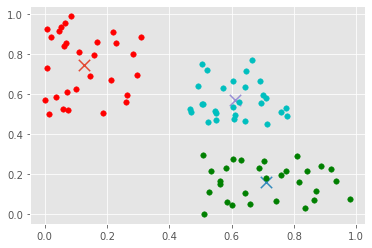

In [99]:
for centroid in km.centroids:
    plt.scatter(km.centroids[centroid][0], km.centroids[centroid][1], s=130, marker="x")
    
for classification in km.classes:
    color = colors[classification]
    for features in km.classes[classification]:
        plt.scatter(features[0], features[1], color=color, s=30)